In [1]:
#!pip install opencv-python

In [2]:
import numpy as np 

c:\users\machine learning\appdata\local\programs\python\python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\machine learning\appdata\local\programs\python\python38\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\users\machine learning\appdata\local\programs\python\python38\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [3]:
import pandas as pd

In [4]:
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline

In [6]:
from PIL import Image

In [7]:
import cv2

In [8]:
import tensorflow as tf

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
from keras.models import Sequential

In [11]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

In [12]:
import random as rnd

In [13]:
import os

In [14]:
import math

In [15]:
IMG_WIDTH = 32

In [16]:
IMG_HEIGHT = 32

In [17]:
IMG_CHANNELS = 1

In [18]:
TRAIN_SIZE = 4000 

In [19]:
TRAIN_PATH = 'trainset/'

In [20]:
TEST_PATH = 'testset/'

In [21]:
ROI_PATH = "roi/"

In [22]:
def get_centers(dir_roi, resol=(2048, 2048)):
    
    img_id = []
    cx_pxl = []
    cy_pxl = []

    HEIGHT, WIDTH = resol
    
    for dirpath, dirnames, files in os.walk(dir_roi):
        sample_id = os.path.split(dirpath)[1].split('.')[0]
        for file in files:
            img_id.append(sample_id + file[:4])
            cx_pxl.append(int(file[10:14]))
            cy_pxl.append(int(file[5:9]))

    df_roi = pd.DataFrame({'img_id': img_id,
                           'cx_pxl': cx_pxl,
                           'cy_pxl': cy_pxl},
                           columns = ['img_id', 'cx_pxl', 'cy_pxl'])
    df_roi['cx'] = df_roi.cx_pxl / float(WIDTH)
    df_roi['cy'] = df_roi.cy_pxl / float(HEIGHT)
            
    return df_roi


def coord_transfm(df_roi_org, shifts=(359, 359), cropped_resol=(1330, 1330)):
    shift_x, shift_y = shifts
    HEIGHT, WIDTH = cropped_resol
    df_roi = df_roi_org.copy()
    df_roi.cx_pxl = df_roi.cx_pxl - shift_x
    df_roi.cy_pxl = df_roi.cy_pxl - shift_y
    df_roi.cx = df_roi.cx_pxl / float(WIDTH)
    df_roi.cy = df_roi.cy_pxl / float(HEIGHT)
    
    return df_roi 


def draw_roi(img_path, img_list, true_centers, pred_centers=None, 
             actual_R=1.5, actual_imgsize=16.38, current_resol=1330, 
             org_resol=2048, rows=1, cols=3, model_name="Model"):
    
    resize_ratio = current_resol / org_resol
    R = math.floor(current_resol * actual_R/(actual_imgsize*resize_ratio))
    
    plt.figure(figsize=(8*cols, 8*rows))
    
    for i, img_id in enumerate(img_list):
        plt.subplot(rows, cols, i+1)
        img = cv2.imread(TRAIN_PATH + img_id + '.png')
        cx = math.floor(true_centers[i, 0] * current_resol)
        cy = math.floor(true_centers[i, 1] * current_resol)        
        
        if pred_centers is not None:
            cx_pred = math.floor(pred_centers[i, 0] * current_resol) 
            cy_pred = math.floor(pred_centers[i, 1] * current_resol)
            img_mod = cv2.circle(img, (cx_pred, cy_pred), R, (0,0,255), 3)  # Mark the predicted center in blue
            img_mod = cv2.circle(img_mod, (cx_pred, cy_pred), round(R*0.05), (0,0,255), -1)  
            img_mod = cv2.circle(img_mod, (cx, cy), R, (255,0,0), 2)  # Mark the true center in red
            img_mod = cv2.circle(img_mod, (cx, cy), round(R*0.05), (255,0,0), -1)  

        else:
            img_mod = cv2.circle(img, (cx, cy), R, (255,0,0), 3)  # Mark the true center in red
            img_mod = cv2.circle(img_mod, (cx, cy), round(R*0.05), (255,0,0), -1)  

        plt.imshow(img_mod)
    
        if pred_centers is not None:
            plt.title("Vitamin D Deficiency Point  \n" + model_name + ": {}\nHuman: {}"
                      .format(str((cx_pred, cy_pred)),
                              str((cx, cy))))
        else:
            plt.title("Vitamin D Deficiency Point: {}".format(str((cx, cy))))   
            



In [23]:
def mirror(df_imgs, flip_axis, img_height=IMG_HEIGHT, img_width=IMG_WIDTH):
    
    pxl_cols = [col for col in df_imgs.columns if 'pxl' in col]
    num_imgs = df_imgs.shape[0]
    img_size = IMG_HEIGHT * IMG_WIDTH
    
    mat_images = df_imgs[pxl_cols].values
    mat_images = mat_images.reshape((num_imgs, IMG_HEIGHT, IMG_WIDTH))
    df_imgs_flip = df_imgs.copy()
    
    assert 'h' in flip_axis or 'v' in flip_axis, \
           "Flipping axis is not defined. Must be either 'horizontal' or 'vertical'."
    
    if 'h' in flip_axis:
        flipping = 1
        df_imgs_flip.img_id = df_imgs.img_id + 'hf'
        df_imgs_flip.cy = 1.0 - df_imgs.cy  
    elif 'v' in flip_axis:
        flipping = 2
        df_imgs_flip.img_id = df_imgs.img_id + 'vf'
        df_imgs_flip.cx = 1.0 - df_imgs.cx    
    
    mat_images_flip = np.flip(mat_images, flipping) \
                        .reshape((num_imgs, img_size))
    df_imgs_flip[pxl_cols] = mat_images_flip
    
    return df_imgs_flip

In [24]:
df_centers_org = get_centers(ROI_PATH).sort_values(by='img_id') \
                                     .reset_index(drop=True)

In [25]:
print(df_centers_org.head())

         img_id  cx_pxl  cy_pxl        cx       cy
0  C00055300022     859    1059  0.419434  0.51709
1  C00055300023     859    1059  0.419434  0.51709
2  C00055300024     859    1059  0.419434  0.51709
3  C00055300025     859    1059  0.419434  0.51709
4  C00055300026     859    1059  0.419434  0.51709


In [26]:
df_centers = coord_transfm(df_centers_org)

In [27]:
print(df_centers.head())

         img_id  cx_pxl  cy_pxl       cx        cy
0  C00055300022     500     700  0.37594  0.526316
1  C00055300023     500     700  0.37594  0.526316
2  C00055300024     500     700  0.37594  0.526316
3  C00055300025     500     700  0.37594  0.526316
4  C00055300026     500     700  0.37594  0.526316


In [28]:
images = pd.Series(sorted(os.listdir(TRAIN_PATH)))

In [29]:
img_ids = images.str.split('.').str[0]

In [30]:
assert df_centers.img_id.equals(img_ids), "Image lists don't match"

In [31]:
img_size = IMG_HEIGHT * IMG_WIDTH

In [32]:
mat_images = np.zeros((TRAIN_SIZE, img_size))

In [33]:
train_images = images.sample(TRAIN_SIZE, random_state=10)

In [34]:
train_img_ids = train_images.str.split('.').str[0]

In [35]:
df_train = pd.DataFrame(mat_images, 
                        columns=['pxl' + str(i) for i in range(img_size)])

In [36]:
df_train.insert(0, 'img_id', train_img_ids.values)

In [37]:
df_train = pd.merge(df_train, df_centers[['img_id', 'cx', 'cy']], 
                    on='img_id', validate="1:1")

In [38]:
print(df_train.head())

         img_id  pxl0  pxl1  pxl2  pxl3  pxl4  pxl5  pxl6  pxl7  pxl8  ...  \
0  C00055410076   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1  C00055900056   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2  C00055680038   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3  C00055310107   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4  C00055750077   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

   pxl1016  pxl1017  pxl1018  pxl1019  pxl1020  pxl1021  pxl1022  pxl1023  \
0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

         cx        cy  
0  0.380451  0.525564  
1  0.514286  0.48947

In [39]:
print(df_train.shape)

(4000, 1027)


In [40]:
df_train_hflip = mirror(df_train, 'h')


In [41]:
df_train_vflip = mirror(df_train, 'v')

In [42]:
df_train = pd.concat([df_train, df_train_hflip, df_train_vflip],
                     ignore_index=True)

In [43]:
print("New dataframe's shape: {}".format(df_train.shape))

New dataframe's shape: (12000, 1027)


In [44]:
df_centers = df_train[['img_id', 'cx', 'cy']]

In [45]:
X = df_train.drop(columns=['img_id', 'cx', 'cy']) \
            .values.reshape((-1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

In [46]:
Y = df_train[['cx', 'cy']].values

In [47]:
IDs = df_train.img_id.values

In [48]:
X /= 255.0

In [49]:
del df_train, df_train_hflip, df_train_vflip, mat_images

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
X_train, X_val, Y_train, Y_val, IDs_train, IDs_val = train_test_split(X, Y, IDs, test_size=0.05, random_state=1)

In [52]:
print("Trainset shape: {}".format(X_train.shape))

Trainset shape: (11400, 32, 32, 1)


In [53]:
print("Validateset shape: {}".format(X_val.shape))

Validateset shape: (600, 32, 32, 1)


In [54]:
select_disp = df_centers.iloc[:TRAIN_SIZE].sample(n=3)

In [55]:
img_list = select_disp['img_id'].values

In [56]:
true_centers = select_disp[['cx', 'cy']].values

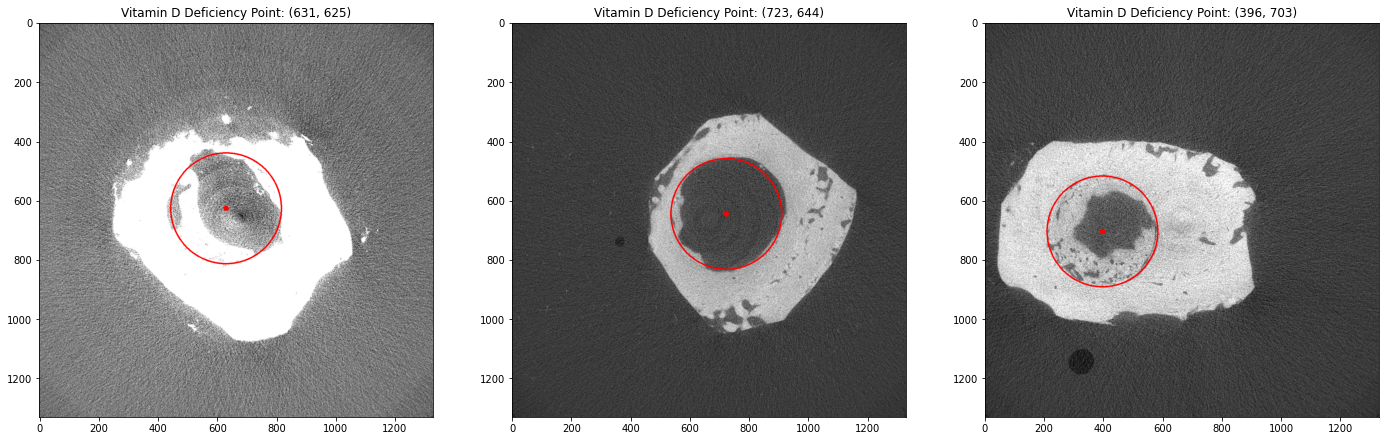

In [57]:
draw_roi(TRAIN_PATH, img_list, true_centers)

In [58]:
rnn_model = Sequential()

In [59]:
rnn_model.add(Conv2D(filters = 32, kernel_size = (5,5), 
                     padding = 'Same', activation ='relu', 
                     input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))

In [60]:
rnn_model.add(Conv2D(filters = 32, kernel_size = (5,5),
                     padding = 'Same', activation ='relu'))

In [61]:
rnn_model.add(MaxPool2D(pool_size=(2,2)))

In [62]:
rnn_model.add(Conv2D(filters = 64, kernel_size = (3,3),
                 padding = 'Same', activation ='relu'))

In [63]:
rnn_model.add(Conv2D(filters = 64, kernel_size = (3,3),
                     padding = 'Same', activation ='relu'))

In [64]:
rnn_model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

In [65]:
rnn_model.add(Flatten())

In [66]:
rnn_model.add(Dense(512, activation = "relu"))

In [67]:
rnn_model.add(Dense(64, activation = "relu"))

In [68]:
rnn_model.add(Dense(2))

In [69]:
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

In [70]:
def mean_dist(y_pred, y_true):
    d = y_pred - y_true
    return tf.reduce_mean(tf.norm(d, axis=1))

In [71]:
import tensorflow as tf
rnn_model.compile(loss=mean_dist, optimizer='adam')
rnn_model.fit(X_train, Y_train, batch_size=64, epochs=8)

Epoch 1/8
135/179 [=====================>........] - ETA: 10s - loss: 0.6162

KeyboardInterrupt: 

In [ ]:
rnn_scores_train = rnn_model.evaluate(X_train, Y_train)
print("Score on trainset: {}".format(rnn_scores_train))
rnn_scores_val = rnn_model.evaluate(X_val, Y_val)
print("Score on validate set: {}".format(rnn_scores_val))

In [ ]:
rnn_pred = rnn_model.predict(X_val, verbose=True)
rnn_results = pd.DataFrame(np.concatenate([rnn_pred, Y_val], axis=1), 
                          columns = ['cx_pred', 'cy_pred', 'cx', 'cy'])
rnn_results.insert(0, 'img_id', IDs_val)
print(rnn_results.head())

In [ ]:
orig = [img_id for img_id in rnn_results.img_id 
        if 'f' not in img_id]
orig_imgs = rnn_results[rnn_results.img_id.isin(orig)]
selt_imgs = orig_imgs.sample(n=6)
img_list = selt_imgs['img_id'].values
true_centers = selt_imgs[['cx', 'cy']].values
pred_centers = selt_imgs[['cx_pred', 'cy_pred']].values

draw_roi(TRAIN_PATH, img_list, true_centers, 
         pred_centers, rows=2, cols=3, model_name="Simple RNN")

In [ ]:
selt_dots = orig_imgs.sample(n=20)
img_list = selt_dots['img_id'].values
true_centers = (selt_dots[['cx', 'cy']].values * 1330).astype(int)
pred_centers = (selt_dots[['cx_pred', 'cy_pred']].values * 1330).astype(int)

plt.figure(figsize = (5, 5))
plt.scatter(true_centers[:, 0], true_centers[:, 1], c='r', alpha=0.5, label='Human')
plt.scatter(pred_centers[:, 0], pred_centers[:, 1], c='b', alpha=0.5, label='RNN model')
plt.axis('equal')
plt.legend()
plt.title("20 Random Selected Images of Bones")
plt.show() 

In [ ]:
rnn_results.to_csv("RNN1.csv")

In [ ]:
from keras import layers
from keras.layers import Input, Add, Activation, ZeroPadding2D, BatchNormalization, \
                         AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.initializers import glorot_uniform

In [ ]:
def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    X_shortcut = X
    X = Conv2D(filters = F1, kernel_size = (1,1), strides = (1,1), 
               padding = 'valid', name = conv_name_base + '2a', 
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1),
               padding = 'same', name = conv_name_base + '2b',
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), 
               padding = 'valid', name = conv_name_base + '2c', 
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name = bn_name_base + '2c')(X)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s=2):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    X_shortcut = X
    X = Conv2D(F1, (1,1), strides = (s,s), name = conv_name_base + '2a',
               padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = Conv2D(F2, (f,f), strides = (1,1), name = conv_name_base + '2b',
               padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = Conv2D(F3, (1,1), strides = (1,1), name = conv_name_base + '2c',
               padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X) 
    X_shortcut = Conv2D(F3, (1,1), strides = (s,s), padding = 'valid',
                        name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X

In [ ]:
def ResNet50(input_shape):
    X_input = Input(input_shape)
    X = ZeroPadding2D((1, 1))(X_input) # mod (3,3) -> (1,1)
    X = Conv2D(64, (3, 3), strides=(1, 1), name='conv1', # mod (7,7) -> (3,3); (2,2) -> (1,1)
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    X = convolutional_block(X, f=3, filters=[64, 64, 256], 
                            stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    X = convolutional_block(X, f=3, filters=[128,128,512],
                            stage=3, block='a', s=2) 
    X = identity_block(X, f=3, filters=[128,128,512], stage=3, block='b')
    X = identity_block(X, f=3, filters=[128,128,512], stage=3, block='c')
    X = identity_block(X, f=3, filters=[128,128,512], stage=3, block='d')
    X = convolutional_block(X, f=3, filters=[256,256,1024],
                            stage=4, block='a', s=2) 
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block='b')
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block='c')
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block='d')
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block='e')
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block='f')
    X = convolutional_block(X, f=3, filters=[512,512,2048],
                            stage=5, block='a', s=2) 
    X = identity_block(X, f=3, filters=[512,512,2048], stage=5, block='b')
    X = identity_block(X, f=3, filters=[512,512,2048], stage=5, block='c')
    X = AveragePooling2D((2,2), name='avg_pool')(X)
    X = Flatten()(X)
    
    X = Dense(2, name='fc_outputs', kernel_initializer=glorot_uniform(seed=0))(X)
    model = Model(inputs = X_input, outputs = X, name = 'Conv2')
    return model

In [ ]:
ResNet_model = ResNet50(input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
ResNet_model.summary()

In [ ]:
ResNet_model.compile(loss=mean_dist, optimizer='adam')
ResNet_model.fit(X_train, Y_train, batch_size=128, epochs=1)

In [ ]:
ResNet_scores_train = ResNet_model.evaluate(X_train, Y_train, batch_size=128)
print("Score on trainset: {}".format(ResNet_scores_train))
ResNet_scores_val = ResNet_model.evaluate(X_val, Y_val)
print("Score on validate set: {}".format(ResNet_scores_val))

In [ ]:
ResNet_pred = ResNet_model.predict(X_val, verbose=True)
ResNet_results = pd.DataFrame(np.concatenate([ResNet_pred, Y_val], axis=1), 
                              columns = ['cx_pred', 'cy_pred', 'cx', 'cy'])
ResNet_results.insert(0, 'img_id', IDs_val)


In [ ]:
type(ResNet_results)



In [ ]:
for rw in ResNet_results.head(10).iterrows():
    print(rw)

In [ ]:
print(ResNet_results.head())

In [ ]:
orig = [img_id for img_id in ResNet_results.img_id 
        if 'f' not in img_id]
orig_imgs = ResNet_results[ResNet_results.img_id.isin(orig)]
selt_imgs = orig_imgs.sample(n=6)
img_list = selt_imgs['img_id'].values
true_centers = selt_imgs[['cx', 'cy']].values
pred_centers = selt_imgs[['cx_pred', 'cy_pred']].values

draw_roi(TRAIN_PATH, img_list, true_centers, pred_centers, 
         rows=2, cols=3, model_name="ResNet50")

In [ ]:
selt_dots = orig_imgs.sample(n=20)
img_list = selt_dots['img_id'].values
true_centers = (selt_dots[['cx', 'cy']].values * 1330).astype(int)
pred_centers = (selt_dots[['cx_pred', 'cy_pred']].values * 1330).astype(int)

plt.figure(figsize = (5, 5))
plt.scatter(true_centers[:, 0], true_centers[:, 1], c='r', alpha=0.5, label='Human')
plt.scatter(pred_centers[:, 0], pred_centers[:, 1], c='b', alpha=0.5, label='RNN with Activations Func')
plt.axis('equal')
plt.legend()
plt.title("20 randomly selected images")
plt.show() 

In [ ]:
# Save results
ResNet_results.to_csv("RNN2_results.csv")

In [ ]:
for rw in ResNet_results.head(1000).iterrows():
    print(type(rw))
    rw[1]["Stage"] = "Stage 5"
    if rw[1]['cy'] < 0.3:
        rw[1]["Stage"] = "Stage 1"
    if rw[1]['cy'] >= 0.3 and rw[1]['cy'] < 0.4:
        rw[1]["Stage"] = "Stage 2"
    if rw[1]['cy'] >= 0.4 and rw[1]['cy'] < 0.5:
        rw[1]["Stage"] = "Stage 3"
    if rw[1]['cy'] >= 0.5 and rw[1]['cy'] < 0.6:
        rw[1]["Stage"] = "Stage 4"
    print(rw)